# Background

## Data Description

Data Description:

The data comes from direct marketing efforts of a European banking institution. The marketing campaign involves making a phone call to a customer, often multiple times to ensure a product subscription, in this case a term deposit. Term deposits are usually short-term deposits with maturities ranging from one month to a few years. The customer must understand when buying a term deposit that they can withdraw their funds only after the term ends. All customer information that might reveal personal information is removed due to privacy concerns.


### Attributes:

| Column	|Description|
|-|-|
|age	|Age of customer (numeric)|
|job	|Type of job (categorical)|
|marital	|Marital status (categorical)|
|education	|Education level (categorical)|
|default	|Has credit in default? (binary)|
|balance	|Average yearly balance, in euros (numeric)|
|housing	|Has a housing loan? (binary)|
|loan	|Has personal loan? (binary)|
|contact	|Contact communication type (categorical)|
|day	|Last contact day of the month (numeric)|
|month	|Last contact month of the year (categorical)|
|duration	|Last contact duration, in seconds (numeric)|
|campaign	|Number of contacts performed during this campaign and for this client (numeric, includes last contact)|

### Output (desired target):

$y$ - has the client subscribed to a term deposit? (binary)

### Goal(s):

- Predict if the customer will subscribe (yes/no) to a term deposit (variable y)
- Find customers who are more likely to buy the investment product. Determine the segment(s) of customers our client should prioritize.
- What makes the customers buy? 


### Success Metric(s):

Hit %81 or above accuracy by evaluating with 5-fold cross validation and reporting the average performance score.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
import seaborn as sns
import xgboost as xgb

In [2]:
csv_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', 'raw', 'term-deposit-marketing-2020.csv'))

## Exploratory data analysis using, JupySQL, SQL queries and DuckDB

**Note**

The queries below asume the usage of JupySQL and Jupyter notebooks.

Ensure the following are installed

```
duckdb-engine
jupysql
```

In [3]:
%load_ext sql
%sql duckdb:///:memory:

In [4]:
query = f"""
CREATE TABLE term_deposit_marketing AS SELECT * FROM read_csv_auto('{csv_path}')
"""

%sql {{query}}


*  duckdb:///:memory:
Done.


Count
40000


In [5]:
f5 = """
    SELECT * FROM term_deposit_marketing LIMIT 5;
"""

%sql {{f5}}

*  duckdb:///:memory:
Done.


age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


## Building the model

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.feature_selection import RFE
from sklearn import metrics

In [7]:
full_data = %sql SELECT * FROM term_deposit_marketing;
data = full_data.DataFrame()


*  duckdb:///:memory:
Done.


Preprocess the data

In [8]:
# Prepare target variable
data['y'] = data['y'].apply(lambda x: 1 if x == 'yes' else 0)

# Define feature columns and target column
X = data.drop(columns=['y'])
y = data['y']

/var/folders/2t/nqb9hcfs07n91h4v5p34slp00000gn/T/ipykernel_39950/134576569.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = X.corr()


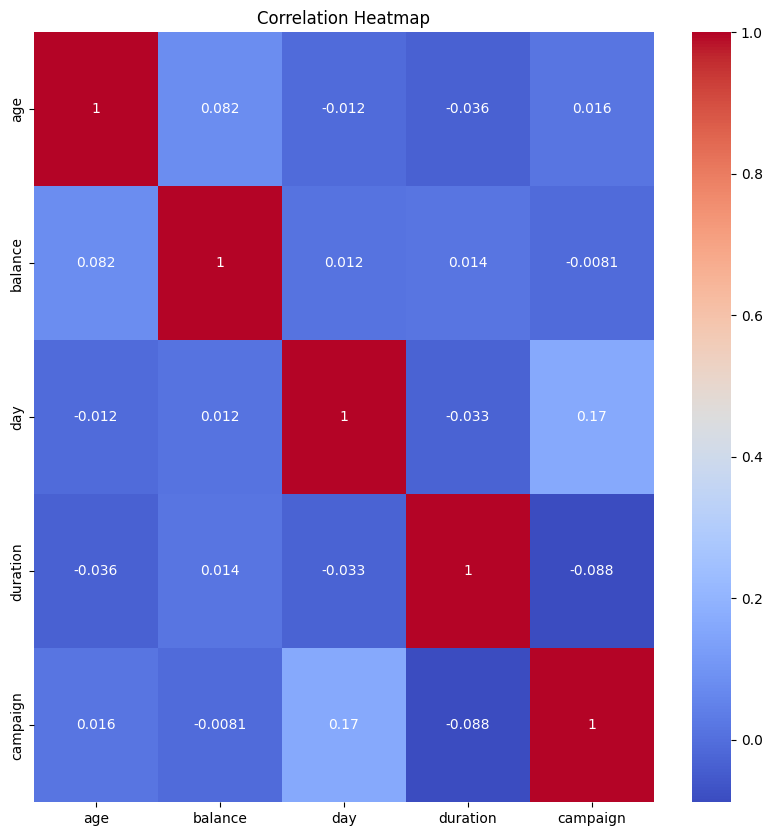

In [9]:
# Perform correlation analysis
corr = X.corr()
corr.style.background_gradient(cmap='coolwarm')

# Generate a correlation heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.savefig(os.path.abspath(os.path.join(os.getcwd(), '..', 'reports', 'figures', 'correlation-heatmap.png')))


Split the data into training and testing datasets

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Create a preprocessing pipeline

In [11]:

def generate_pipeline(X, model):
    # Identify categorical and numerical columns
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

    # Define transformers for categorical and numerical columns
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    numerical_transformer = StandardScaler()

    # Create a column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])
    
    # Create a pipeline with preprocessing and RandomForestClassifier
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', model)])
    
    return pipeline

Create a pipeline and fit the model

In [12]:
# Create a pipeline with preprocessing and RandomForestClassifier
pipeline = generate_pipeline(X, xgb.XGBClassifier(random_state=42))

# Perform 5-fold cross-validation
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')

# Calculate the average accuracy
avg_accuracy = cv_scores.mean()

print("5-fold Cross-validation Accuracy:", avg_accuracy)

success_metric = 0.81

if avg_accuracy >= success_metric:
    print("Success: The average accuracy is above or equal to the success metric.")
else:
    print("Failure: The average accuracy is below the success metric.")


5-fold Cross-validation Accuracy: 0.590275
Failure: The average accuracy is below the success metric.


Make predictions and evaluate

In [13]:
# Fit the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'balance', 'day',
                                                   'duration', 'campaign']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

In [14]:
# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9380833333333334
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     11128
           1       0.61      0.42      0.50       872

    accuracy                           0.94     12000
   macro avg       0.78      0.70      0.73     12000
weighted avg       0.93      0.94      0.93     12000



Although accuracy is high, 5-fold Cross-validation Accuracy: 0.4821
Failure: The average accuracy is below the success metric.

To improve it we can try

1. Feature Engineering: Create new features or transform existing features to better represent the underlying patterns in the data. For example, you can try creating interaction features, binning continuous variables, or extracting meaningful information from categorical variables.

2. Feature Selection: Remove irrelevant or redundant features from the dataset. You can use techniques such as Recursive Feature Elimination (RFE), SelectKBest, or LASSO regularization to identify the most important features for the model.

3. Hyperparameter Tuning: Optimize the hyperparameters of the model to improve its performance. You can use techniques like Grid Search or Randomized Search to find the best combination of hyperparameters for your model.

4. Model Selection: Experiment with different classification algorithms to see if any other model performs better on your dataset. Some examples include Logistic Regression, Support Vector Machines, Decision Trees, Gradient Boosting, or Neural Networks.

5. Address Imbalanced Data: If the target variable is imbalanced (i.e., one class is significantly more frequent than the other), you can try using techniques such as oversampling the minority class, undersampling the majority class, or using Synthetic Minority Over-sampling Technique (SMOTE) to balance the class distribution.

6. Ensemble Methods: Combine multiple models to improve overall performance. You can use techniques like Bagging, Boosting, or Stacking to create an ensemble of models that collectively provide better predictions.

7. Regularization: Apply regularization techniques such as L1 or L2 regularization to prevent overfitting and improve generalization.

### Feature selection

In [15]:
import itertools
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'balance', 'day',
                                                   'duration', 'campaign']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

In [18]:
# Split the data into training and testing sets
y = data['y']
X = data.drop(['y'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

# Define transformers for categorical and numerical columns
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numerical_transformer = StandardScaler()

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create a pipeline with preprocessing, RFE, and RandomForestClassifier
clf = RandomForestClassifier(random_state=42)
rfe = RFE(estimator=clf, n_features_to_select=4, step=1)
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('rfe', rfe),
                           ('classifier', clf)])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')

# Calculate the average accuracy
avg_accuracy = cv_scores.mean()

print("5-fold Cross-validation Accuracy:", avg_accuracy)